In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
soup =BeautifulSoup(content, 'lxml')

In [5]:
data = soup.findAll(text=re.compile("Last update: .+"))
data

['Last update: 11 February 2020 at 2:01 a.m. ET']

In [6]:
m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
data_date_time = ' '.join([m.group(1), m.group(2)])
data_date_time = re.sub("[\.]","",data_date_time)
data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-02-11 02:01'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)

3

### International

In [9]:

df_intl =dfs[2]
df_intl.columns = df_intl.iloc[0]
df_intl.drop(axis=1, index=0, inplace=True)
df_intl

,INTERNATIONAL,Cases,Deaths,Notes,Links
1,Japan,163*,0,4 recovered,Source
2,Singapore,45,0,"7 critical, 7 recovered",Source
3,Thailand,32,0,"1 serious, 10 recovered",Source
4,South Korea,28,0,4 recovered,Source
5,Malaysia,18,0,"16 stable, 1 recovered",Source
6,Australia,15,0,5 recovered,Source
7,Germany,14,0,NaN,Source
8,Vietnam,15,0,6 recovered,Source
9,United States,13,0,3 recovered,Source
10,France,11,0,1 serious,Source


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)

#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(re.sub('[^\d]+', '', x)) for x in row ])
df_intl_cases

international,Japan,Singapore,Thailand,South Korea,Malaysia,Australia,Germany,Vietnam,United States,France,...,Italy,Russia,Spain,Nepal,Cambodia,Sri Lanka,Finland,Sweden,Belgium,TOTAL
0,,,,,,,,,,,,,,,,,,,,,
cases,163,45,32,28,18,15,14,15,13,11,...,3,2,2,1,1,1,1,1,1,396


In [12]:
df_intl_cases = df_intl_cases.drop(['TOTAL'], axis=1)

In [13]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
df_intl_cases

international,datetime,Japan,Singapore,Thailand,South Korea,Malaysia,Australia,Germany,Vietnam,United States,...,India,Italy,Russia,Spain,Nepal,Cambodia,Sri Lanka,Finland,Sweden,Belgium
0,,,,,,,,,,,,,,,,,,,,,
cases,2020-02-11 02:01,163,45,32,28,18,15,14,15,13,...,3,3,2,2,1,1,1,1,1,1


#### Save to file

In [14]:
from pathlib import Path
csv_file = 'data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)

    df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [15]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Australia,Belgium,Cambodia,Canada,Finland,France,Germany,India,Italy,Japan,...,Singapore,South Korea,Spain,Sri Lanka,Sweden,Thailand,UAE,United Kingdom,United States,Vietnam
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,15,1,1,5,1,6,12,3,2,45,...,28,23,1,1,1,25,5,2,12,12
2020-02-06 08:19,15,1,1,5,1,6,13,3,2,45,...,28,23,1,1,1,25,5,3,12,12
2020-02-06 09:01,15,1,1,5,1,6,13,3,2,45,...,30,23,1,1,1,25,5,3,12,12
2020-02-06 09:46,15,1,1,5,1,6,13,3,2,45,...,30,23,1,1,1,25,5,3,12,12
2020-02-06 17:56,15,1,1,7,1,6,13,3,3,45,...,30,23,1,1,1,25,5,3,12,12
2020-02-06 18:06,15,1,1,7,1,6,13,3,3,45,...,30,23,1,1,1,25,5,3,12,12
2020-02-06 19:39,15,1,1,7,1,6,13,3,3,86,...,30,24,1,1,1,25,5,3,12,12
2020-02-06 21:56,15,1,1,7,1,6,13,3,3,86,...,30,24,1,1,1,25,5,3,12,12
2020-02-06 22:53,15,1,1,7,1,6,13,3,3,86,...,30,24,1,1,1,25,5,3,12,12


In [16]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-02-11 02:01')

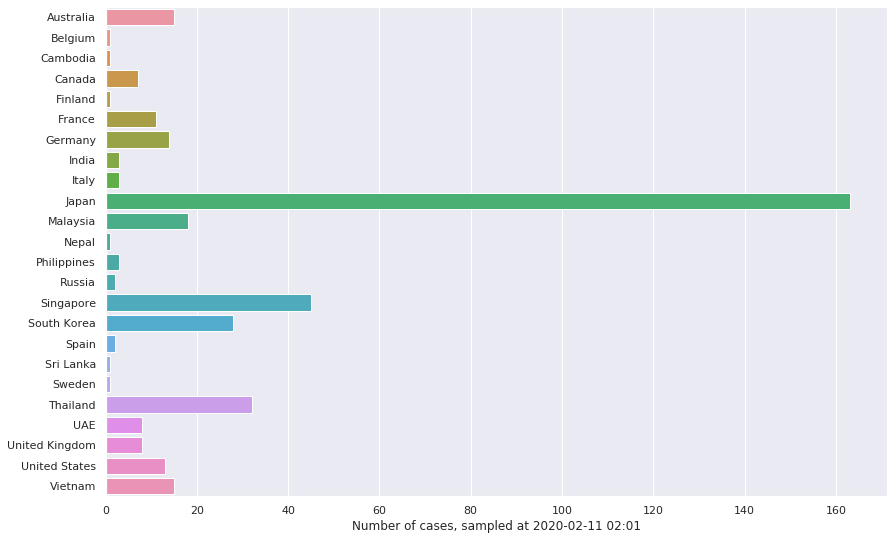

In [17]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,9)})
ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)



In [18]:
png_file='images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)